In [314]:
import json
import regex as re
import random
import datetime
import requests
import time
import pandas as pd
import pymongo
from collections import Counter
import matplotlib.pyplot as plt 
import numpy as np


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score

In [6]:
def get_player_ids_by_country(country):
    '''use the country's 2-character ISO 3166 code (capitalized) to specify which country you want data 
       for example: United States = US'''
    
    url = f'https://api.chess.com/pub/country/{country}/players'
    response = requests.get(url)
    
    #check if the request worked
    assert response.status_code == 200 
    
    #convert from bytes to utf-8, then to json then pull the names from the dict
    return json.loads(response.content.decode('utf-8'))['players']

def date_joined(username, datetype='epoch'):
    '''returns the date the user joined in epoch time by default, human readable date is returned if datetype=readable'''
    
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}')
        profile = json.loads(response.content.decode('utf-8'))
        if datetype == 'epoch':
            return profile['joined']
        elif datetype == 'readable':
            return datetime.datetime.fromtimestamp(profile['joined']).strftime('%c')
    except:
        return -1

def list_of_players(country, start, end, num_of_players):
    '''use the country's 2-character ISO 3166 code (capitalized) to specify which country you want data from
    Params:
         country: which country players will be selected from ex: US
         start: select players who signed up after this date in epoch time ex: 1514764800 (jan 1st, 2018)
         end: select players who signed up before this date in epoch time ex: 1517443200 (feb 1st, 2018)
         num_of_players: amount of players to analyze 
    '''
    
    #random pick from list of usernames
    player_list = random.sample(get_player_ids_by_country(country), 100000)

#     players = []

    for player in player_list:
        player_count = 0
        joined = date_joined(player)
        if player_count == num_of_players:
            break
        elif (joined > start) and joined < end:
            player_count += 1
#             players.append(player)
            yield player
#     return players

def get_player_profile(username):
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}')
        return json.loads(response.content.decode('utf-8'))
    except:
        return [] 
        
def get_player_stats(username):
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}/stats')
        return json.loads(response.content.decode('utf-8'))
    except:
        return []

def get_monthly_archives(username):
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}/games/archives')
        return json.loads(response.content.decode('utf-8'))
    except:
        return []
        
def get_player_games(username, year='2018'):
    '''return a list of lists where each list contains the games played each month'''
    
    months_with_games_played = get_monthly_archives(username)
    months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    games = []
    for month in months:
        try:
            response = requests.get(f'https://api.chess.com/pub/player/{username}/games/{year}/{month}')
            month_games.append([json.loads(response.content.decode('utf-8'))])
        except:
            continue
    return games

def player_data_to_mongoDB(username, mongoDB_connection, database, collection):
    
    mc = mongoDB_connection
    
    #use/create a database
    db = mc[database]
    
    #use/create a collection
    collection = db[collection]
    
    #query Chess.com api for data
    profile = get_player_profile(username)
    games = get_player_games(username)
    
    #insert player data into database
    collection.insert_one({**profile,
                           'games': games
                            })

def all_player_data_to_mongoDB(players, mongoDB_connection, database, collection, verbose=False):
    '''insert all player data into a mongoDB
       Params:
          players: list of player names
          mongoDB_connection: open connection to database ex. pymongo.MongoClient()
          database: name of database
          collection: name of collection
       Keyword Args:
          verbose: if True print player name after each insert, default is False
    '''
    print(f'importing to {database} database and {collection} collection')
    for player in players:
        player_data_to_mongoDB(player, mongoDB_connection, database, collection)
        if verbose:
            print(player)
    print('All player data inserted into database')
            
def mongoDB_to_pandas(database, collection):
    return pd.DataFrame(list(database[collection].find()))
            
def player_data_to_pandas(database, collection, country, start, end, num_of_players):
    '''return a pandas dataframe with all player data'''
    all_player_data_to_mongoDB(list_of_players(country, start, end, num_of_players), pymongo.MongoClient(), database, collection)
    return mongoDB_to_pandas(database, collection)







def games_in_a_month(games_column, player, month):
    return len(games_column[player][month][0]['games'])
    
def rated_games(games_column, player, month, game):
    return str(games_column[player][month][0]['games'][game]['rated'])

def time_class_games(games_column, player, month, game):
    return games_column[player][month][0]['games'][game]['time_class']

def rules_games(games_column, player, month, game):
    return games_column[player][month][0]['games'][game]['rules']

def eco_games(games_column, player, month, game):
    return games_column[player][month][0]['games'][game]['eco'][31:].split('-')[0]

def results_games(games_column, player, month, game):
    if games_column[player][month][0]['games'][game]['white'] == df.username[0]:
        return games_column[player][month][0]['games'][game]['white']['result']
    else:
        return games_column[player][month][0]['games'][game]['black']['result']

def make_columns(features, df, index):
    '''Counts the appearances of each type of outcome then creates a column in the dataframe corresponding to
    that outcome and filling in the number of occurrences for each player
    Params:
        features: List of each outcome ex: [c, a, a, d, d, a, d, c, j]
        df: pandas dataframe
        index: index to locate each player
    '''
    counters = Counter()
    for feature in features:
        counters[feature] += 1

    for counter in counters:
        df.loc[index, counter] = counters[counter]


def parse_games(df, column='games', verbose=False):
    '''Pull out stats from the column containing games and add columns to the datafram inplace for the stats
    Params:
        df: pandas dataframe
    Keyword Args:
        column: column containing games, default column name is 'games'
        verbose: if True, print player indices as they are parsed, default is False
    '''
    print('parsing...')
    games_column = df[column]
    player_idx = range(df.shape[0])
    for player in player_idx:
        if verbose:
            print(player)
        rated = []
        time_class = []
        rules = []
#         eco = []
        results = []
        if len(games_column[player]) != 5:
            continue
        else:
            for month in range(4):
                try:
                    for game in range(games_in_a_month(games_column, player, month)):
                        try:
                            rated.append(rated_games(games_column, player, month, game))
                        except KeyError:
                            continue
                        try:
                            time_class.append(time_class_games(games_column, player, month, game))
                        except KeyError:
                            continue
                        try:
                            rules.append(rules_games(games_column, player, month, game))
                        except KeyError:
                            continue
#                         try:
#                             eco.append(eco_games(games_column, player, month, game))
#                         except KeyError:
#                             continue
                        try:
                            results.append(results_games(games_column, player, month, game))
                        except KeyError:
                            continue
                except KeyError:
                    continue
                    
            df.loc[player, 'may_games'] = games_in_a_month(games_column, player, 4)
            
            make_columns(time_class, df, player)
            make_columns(rated, df, player)
            make_columns(rules, df, player)
            make_columns(eco, df, player)
            make_columns(results, df, player)
            
def init_columns(df):
    '''Add columns for all rated games, time_class, rules
    Params:
        df: pandas dataframe
    '''
    labels = ['win', 'checkmated', 'agreed', 'repetition', 'timeout', 'resigned', 
              'stalemate', 'lose', 'insufficient', '50move', 'abandoned', 'kingofthehill',
              'threecheck', 'timevsinsufficient', 'bughousepartnerlose', 'False', 'True',
              'standard', 'daily', 'blitz', 'lightning', 'chess960', 'crazyhouse', 'bughouse', 'chess']
    for label in labels:
        df[label] = 0
        
def make_X_and_y(df):
    '''make all feature columns and target column
    Params:
        df: pandas datafram
    Returns:
        X: all important feature columns
        y: target column, 1 (inactive: less than 2 games played during the last month) or 0 (active)
    '''
    print('making features and target')
    #initialize columns
    init_columns(df)

    #parse games column
    parse_games(df)
    
    #rename True and False columns to rated and unrated
    df.rename(columns={'True': 'rated', 'False': 'unrated'}, inplace=True)

    #create inactive column (1 = inactive, 0 = active) inactive if they have not played a game in two weeks (may 1st)
    def is_inactive(x):
        '''checks if value is less than 2
        '''
        if x < 2:
            return 1
        else:
            return 0

    df['inactive'] = df['may_games'].apply(lambda x: is_inactive(x))

    #create columns has_name, has_location, has_avatar
    def has_attribute(x):
        if x != x:
            return 0
        else:
            return 1

    df['has_name'] = df['name'].apply(lambda x: has_attribute(x))
    df['has_location'] = df['location'].apply(lambda x: has_attribute(x))
    df['has_avatar'] = df['avatar'].apply(lambda x: has_attribute(x))

    #make a basic account type column
    def is_basic(x):
        '''check if value is the string basic'''
        if x == 'basic':
            return 1
        else:
            return 0

    df['is_basic'] = df['status'].apply(lambda x: is_basic(x))

    #make a premium account type column
    def is_premium(x):
        '''check if value is the string premium'''
        if x == 'premium':
            return 1
        else:
            return 0

    df['is_premium'] = df['status'].apply(lambda x: is_premium(x))
    
    #assign X and y variables
    y = df['inactive']
    
    X = df.drop(columns=['@id', '_id', 'avatar', 'chess960_daily', 'chess_blitz',
                         'chess_bullet', 'chess_daily', 'chess_rapid', 'country',
                         'games', 'last_online', 'location', 'name', 'player_id',
                         'status', 'url', 'username', 'may_games', 'inactive'])
    
    return (X, y)

def api_to_random_forest(database, collection, country, start, end, num_of_players):
    '''returns the AUC score and a fit random forest model
    Params:
         country: which country players will be selected from ex: US
         start: select players who signed up after this date in epoch time ex: 1514764800 (jan 1st, 2018)
         end: select players who signed up before this date in epoch time ex: 1517443200 (feb 1st, 2018)
         num_of_players: amount of players to analyze 
    '''
    player_data_to_pandas(database, collection, country, start, end, num_of_players)

    #remove duplicate users by player_id
    df.drop_duplicates(subset='player_id', inplace=True)

    #reset the index
    df.reset_index(drop=True, inplace=True)

    #create features and target
    X, y = make_X_and_y(df)

    print('train, test, spliting')
    #make a train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    print('making predictions....')
    #make predictions using random forest
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train, y_train)
    y_predict = random_forest.predict_proba(X_test)
    
    return (roc_auc_score(y_test, y_predict[:, 1]), random_forest)

In [ ]:
my_whole_project('chess_predictions', 'players_testrun2', 'US', 1514764800, 1517443200, 10)

importing to chess_predictions database and players_testrun2 collection


In [58]:
all_player_data_to_mongoDB(full_player_names, pymongo.MongoClient(), 'chess_predictions', 'players', verbose=True)

0ldtower
0rlandomagic
0xvyper
101arrowz
108daniel
10thplanetchess
1103chucky
1122mata
11brian11
12122323
123babelfish
123paulb
1336067
141269
153fishfromthesea
1985has
1995diakonia
19ccollins
19raidernation74
1ferdman
1foutsda1
1kingservant
1ln
1nghia
1srose80
1timbob
2000horses
2015sti
201701573
209rayzor
21jtworks
21kaladi
22cabbage
23shaman
29tonygong
2bfenn
2elvemsrs
2old2slow
2pawn1
2weeeeee
300wssm
32010204
321collins
3c0x1
3happiness
40dog
48823
49erdude
4movegroove
4play1132
4rkum8
50york
510tone
60piece
66iglesias
6jfisher
70281381
72treadaway
77746920
777lucky69
7miledb
7myboyz7
7teal7
804659
889874
8ibol
8pawnproblem
9011935
9729037
9fa
9kanth
a_e_s_t_h_e_t_e
a_faliure
a-arons
a-club
a3cow05
a67cabrera
aa_ethan_zz
aaachesstrack101
aabdullah014
aag02013
aardjess
aarfo38
aaronak47
aaronbel88
aaroncz
aaroneicoff
aaronjonasen
aaronwingert
aaverbuj
aawp
abarnard1
abbank
abc92zxc
abcde45
abdikafigeedi
abdulameer1
abe-city
abelcastaneda
abelskinner
abhishastry123
abhishekyadav1098


In [57]:
player_data_to_mongoDB('0rlandomagic', pymongo.MongoClient(), 'chess_predictions', 'players')

# Important Endpoints from Chess.com

## Player Profile
### Description: Get additional details about a player in a game. 
URL pattern: https://api.chess.com/pub/player/{username} 

{
  "@id": "URL", // the location of this profile (always self-referencing)
  
  "url": "URL", // the chess.com user's profile page (the username is displayed with the original letter case)
  
  "username": "string", // the username of this player
  
  "player_id": 41, // the non-changing Chess.com ID of this player
  
  "title": "string", // (optional) abbreviation of chess title, if any
  
  "status": "string", // account status: closed, closed:fair_play_violations, basic, premium, mod, staff
  
  "name": "string", // (optional) the personal first and last name
  
  "avatar": "URL", // (optional) URL of a 200x200 image
  
  "location": "string", // (optional) the city or location
  
  "country": "URL", // API location of this player's country's profile
  
  "joined": 1178556600, // timestamp of registration on Chess.com
  
  "last_online": 1500661803, // timestamp of the most recent login
  
  "followers": 17 // the number of players tracking this player's activity
}


## Player Stats
### Description: Get ratings, win/loss, and other stats about a player's game play. 
URL pattern: https://api.chess.com/pub/player/{username}/stats

"chess_daily": {
/* stats object for games of rules "chess" and "daily" time-class */


"chess960_daily": {
/* stats object for games of rules "chess960" and "daily" time-class */


"chess_blitz": {
/* stats object for games of rules "chess" and "blitz" time-class */


### In each dictionary:

{
  "last": { // the current stats
  
    "date": 1509709165, // timestamp of the last rated game finished
    
    "rating": 1642, // most-recent rating
    
    "rd": 58 // the Glicko "RD" value used to calculate ratings changes
    
  },
  "best": { // the best rating achieved by a win
  
    "date": 1256228875, // timestamp of the best-win game
    
    "rating": 2065, // highest rating achieved
    
    "game": "URL" // URL of the best-win game
    
  },
  "record": { // summary of all games played
  
    "win": 177,  // number of games won
    
    "loss": 124, // number of games lost
    
    "draw": 21,  // number of games drawn
    
    "time_per_move": 18799, // integer number of seconds per average move
    
    "timeout_percent": 9.99 // timeout percentage in the last 90 days
    
    
  },
  "tournament": { // summary of tournaments participated in
  
    "count": 20,   // number of tournaments joined
    
    "withdraw": 1, // number of tournaments withdrawn from
    
    "points": 39,  // total number of points earned in tournaments
    
    "highest_finish": 1 // best tournament place
  }
}

## List of Monthly Archives
### Description: Array of monthly archives available for this player. 
URL pattern: https://api.chess.com/pub/player/{username}/games/archives


  "archives":
    /* array of URLs for monthly archives in ascending chronological order */

## Complete Monthly Archives
### Description: Array of Live and Daily Chess games that a player has finished. 
URL pattern: https://api.chess.com/pub/player/{username}/games/{YYYY}/{MM}

"YYYY" is the four digit year of the game-end

"MM" is the two-digit month

Data Format, each Game:

{
  "white": { // details of the white-piece player:
  
    "username": "string", // the username
    
    "rating": 1492, // the player's rating at the start of the game
    
    "result": "string", // see "Game results codes" section
    
    "@id": "string", // URL of this player's profile
    
  },
  "black": { // details of the black-piece player:
  
    "username": "string", // the username
    
    "rating": 1942, // the player's rating at the start of the game
    
    "result": "string", // see "Game results codes" section
    
    "@id": "string", // URL of this player's profile
    
  },
  "url": "string", // URL of this game
  
  "fen": "string", // final FEN
  
  "pgn": "string", // final PGN
  
  "start_time": 1254438881, // timestamp of the game start (Daily Chess only)
  
  "end_time": 1254670734, // timestamp of the game end
  
  "time_control": "string", // PGN-compliant time control
  
  "rules": "string", // game variant information (e.g., "chess960")
  
  "eco": "string", //URL pointing to ECO opening (if available),
  
  "tournament": "string", //URL pointing to tournament (if available),  
  
  "match": "string", //URL pointing to team match (if available)  
  
}

In [4]:
def get_monthly_archives(username):
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}/games/archives')
        months_played = json.loads(response.content.decode('utf-8'))['archives']
        return [month[-7:].split('/') for month in months_played]
    except:
        return []
        
def get_player_games(username):
    '''return a list of all games played by a user'''
    
    months = get_monthly_archives(username)
    games = []
    if months:
        for month in months:
            year = month[0]
            month = month[1]
            response = requests.get(f'https://api.chess.com/pub/player/{username}/games/{year}/{month}')
            for game in json.loads(response.content.decode('utf-8'))['games']:
                games.append(game)
    return games

In [235]:
get_player_games('4swb')

[{'black': {'@id': 'https://api.chess.com/pub/player/catali',
   'rating': 1146,
   'result': 'resigned',
   'username': 'catali'},
  'end_time': 1406239188,
  'fen': '8/8/2p3k1/1p1p4/1P3KP1/P1P5/7P/8 b - g3',
  'pgn': '[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2014.07.24"]\n[Round "-"]\n[White "4swb"]\n[Black "catali"]\n[Result "1-0"]\n[ECO "C00"]\n[ECOUrl "https://www.chess.com/openings/C00-French-Defense-Knight-Variation-2...d5"]\n[WhiteElo "1184"]\n[BlackElo "1166"]\n[TimeControl "600"]\n[Termination "4swb won by resignation"]\n[StartTime "21:59:48"]\n[EndDate "2014.07.24"]\n[EndTime "21:59:48"]\n[Link "https://www.chess.com/live/game/869038626"]\n\n1. e4 {[%clk 0:10:00]} 1... e6 {[%clk 0:10:00]} 2. Nf3 {[%clk 0:09:55.8]} 2... d5 {[%clk 0:09:57.6]} 3. exd5 {[%clk 0:09:45.9]} 3... exd5 {[%clk 0:09:53.8]} 4. d4 {[%clk 0:09:42.7]} 4... Nf6 {[%clk 0:09:52]} 5. Nc3 {[%clk 0:09:33.6]} 5... Bb4 {[%clk 0:09:48.4]} 6. Bd2 {[%clk 0:09:28.8]} 6... c6 {[%clk 0:09:39]} 7. Be2 {[%clk 0:09

In [236]:
g = _

In [267]:
g[150]['pgn']

'[Event "Live Chess"]\n[Site "Chess.com"]\n[Date "2014.08.01"]\n[Round "-"]\n[White "Magoo4u"]\n[Black "4swb"]\n[Result "0-1"]\n[ECO "B20"]\n[ECOUrl "https://www.chess.com/openings/B20-Sicilian-Defense"]\n[WhiteElo "1100"]\n[BlackElo "1436"]\n[TimeControl "1800"]\n[Termination "4swb won - game abandoned"]\n[StartTime "03:04:04"]\n[EndDate "2014.08.01"]\n[EndTime "03:04:04"]\n[Link "https://www.chess.com/live/game/875345916"]\n\n1. e4 {[%clk 0:28:58.5]} 1... c5 {[%clk 0:29:14.7]} 0-1'

In [266]:
re.split("(\d+)\.+ ", g[150]['pgn'])[-2]

'1'

In [252]:
re.split("(\d+\.+ )", g[1635]['pgn'].split('\n\n')[-1])

['', '1. ', 'e4 {[%clk 0:10:00]} 1-0']

In [260]:
re.split(" (\d+)\.", g[34]['pgn'])[-2]
    

'16'

In [97]:
num[:2]

'19'

In [268]:
def game_stats_df(username):
    game_list = get_player_games(username)
    player_rating = []
    player_result = []
    player_username = []
    end_time = []
    pgn = []
    eco = []
    rated = []
    time_class = []
    rules = []
    game_length = []

    for i, game in enumerate(game_list):
        
        starting_position = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq -'
        
        if (game['rules'] == 'chess') and (game['fen'] != starting_position):
            pgn_data = game['pgn'].split('\n')
            pgn.append(pgn_data[-1])
            eco.append(pgn_data[7].split('"')[-2])
            game_length.append(int(re.split("(\d+)\.+", game['pgn'])[-2]))
            print(i, re.split("(\d+)\.+", game['pgn'])[-2])
        else:
            pgn.append(None)
            eco.append(None)
            game_length.append(None)
            
        if game['black']['username'].lower() == username.lower():
            player_rating.append(game['black']['rating'])
            player_result.append(game['black']['result'])
            player_username.append(game['black']['username'])
        else:
            player_rating.append(game['white']['rating'])
            player_result.append(game['white']['result'])
            player_username.append(game['white']['username'])
            
        end_time.append(pd.to_datetime(game['end_time'], unit='s'))
        rated.append(game['rated'])
        time_class.append(game['time_class'])
        rules.append(game['rules'])

    df = pd.DataFrame({'player_username': player_username,
                       'player_rating': player_rating,
                       'player_result': player_result,
                       'end_time': end_time,
                       'rated': rated,
                       'time_class': time_class,
                       'rules': rules,
                       'pgn': pgn,
                       'eco': eco,
                       'game_length':game_length})
    return df

In [269]:
stats_df = game_stats_df('4swb')

0 53
1 27
2 19
3 54
4 56
5 51
6 55
7 48
8 49
9 38
10 04
11 54
12 18
13 33
14 52
15 43
16 15
17 13
18 53
19 32
20 06
21 13
22 56
23 11
24 29
25 00
26 02
27 14
28 54
29 44
30 51
31 58
32 33
33 29
34 17
35 00
36 21
37 11
38 28
39 51
40 37
41 47
42 18
43 07
44 03
45 33
46 39
47 08
48 45
49 02
50 43
51 11
52 52
53 29
54 51
55 40
56 08
57 58
58 43
59 40
60 45
61 17
62 58
63 22
64 08
65 20
66 02
67 44
68 53
69 21
70 53
71 14
72 37
73 39
74 26
75 50
76 38
77 03
78 31
79 24
80 31
81 33
82 25
83 11
84 33
85 06
86 50
87 29
88 56
89 53
90 18
91 11
92 04
93 37
94 33
95 4
96 28
97 34
98 26
99 25
100 18
101 09
102 37
103 37
104 28
105 23
106 35
107 39
108 02
109 44
110 42
111 59
112 30
113 10
114 40
115 25
116 19
117 48
118 36
119 00
120 34
121 38
122 28
123 05
124 24
125 35
126 10
127 33
128 20
129 43
130 31
131 55
132 24
133 14
134 53
135 50
136 05
137 49
138 56
139 59
140 32
141 40
142 32
143 26
144 54
145 24
146 31
147 42
148 22
149 32
150 14
151 22
152 58
153 35
154 47
155 22
156 16
157 04
158 4

1200 46
1201 18
1202 41
1203 48
1204 58
1205 07
1206 14
1207 17
1208 48
1209 41
1210 55
1211 09
1212 00
1213 19
1214 55
1215 18
1216 18
1217 54
1218 11
1219 33
1220 53
1221 58
1222 07
1223 35
1224 09
1225 01
1226 31
1227 23
1228 25
1229 28
1230 23
1231 54
1232 47
1233 39
1234 37
1235 00
1236 09
1237 26
1238 42
1239 01
1240 45
1241 04
1242 29
1243 48
1244 39
1245 15
1246 31
1247 02
1248 00
1249 61
1250 17
1251 00
1252 21
1253 27
1254 16
1255 24
1256 43
1257 26
1258 30
1259 47
1260 34
1261 28
1262 47
1263 17
1264 19
1265 38
1266 25
1267 57
1268 29
1269 57
1270 20
1271 23
1272 44
1273 48
1274 15
1275 02
1276 34
1277 28
1278 27
1279 17
1280 34
1281 03
1282 46
1283 37
1284 07
1285 39
1286 05
1287 11
1288 45
1289 49
1290 16
1291 52
1292 34
1293 31
1294 26
1295 20
1296 21
1297 44
1298 35
1299 16
1300 30
1301 32
1302 03
1303 39
1304 53
1305 50
1306 18
1307 14
1308 25
1309 31
1310 47
1311 15
1312 40
1313 41
1314 50
1315 44
1316 12
1317 13
1318 51
1319 46
1320 54
1321 45
1322 53
1323 49
1324 43


2424 08
2425 06
2426 19
2427 45
2428 33
2429 33
2430 23
2431 04
2432 18
2433 19
2434 03
2435 37
2436 46
2437 47
2438 15
2439 31
2440 06
2441 19
2442 37
2443 25
2444 24
2445 17
2446 36
2447 16
2448 21
2449 50
2450 24
2451 15
2452 23
2453 01
2454 55
2455 27
2456 56
2457 11
2458 32
2459 35
2460 13
2461 55
2462 37
2463 46
2464 50
2465 23
2466 37
2467 34
2468 56
2469 20
2470 40
2471 05
2472 39
2473 52
2474 40
2475 07
2476 31
2477 36
2478 30
2479 43
2480 46
2481 59
2482 12
2483 00
2484 12
2485 26
2486 09
2487 11
2488 35
2489 48
2490 10
2491 21
2492 25
2493 46
2494 32
2495 06
2496 52
2497 22
2498 22
2499 50
2500 49
2501 47
2502 25
2503 56
2504 29
2505 30
2506 46
2507 35
2508 37
2509 18
2510 39
2511 46
2512 42
2513 51
2514 59
2515 25
2516 24
2517 45
2518 30
2519 40
2520 33
2521 34
2522 14
2523 07
2524 46
2525 50
2526 55
2527 50
2528 09
2529 07
2530 43
2531 41
2532 03
2533 43
2534 46
2535 10
2536 41
2537 53
2538 29
2539 12
2540 35
2541 17
2542 01
2543 12
2544 37
2545 32
2546 16
2547 23
2548 33


3674 50
3675 59
3676 40
3677 16
3678 51
3679 13
3680 08
3681 16
3682 56
3683 01
3684 06
3685 19
3686 52
3687 13
3688 58
3689 53
3690 56
3691 17
3692 40
3693 29
3694 06
3695 16
3696 40
3697 29
3698 42
3699 24
3700 58
3701 08
3702 23
3703 29
3704 40
3705 15
3706 05
3707 13
3708 07
3709 44
3710 06
3711 55
3712 39
3713 32
3714 26
3715 56
3716 45
3717 24
3718 53
3719 32
3720 40
3721 29
3722 58
3723 08
3724 32
3725 48
3726 34
3727 05
3728 57
3729 36
3730 32
3731 54
3732 01
3733 47
3734 14
3735 24
3736 42
3737 53
3738 18
3739 00
3740 36
3741 37
3742 09
3743 19
3744 26
3745 33
3746 38
3747 10
3748 59
3749 31
3750 50
3751 47
3752 12
3753 42
3754 50
3755 13
3756 45
3757 05
3758 35
3759 29
3760 10
3761 18
3762 41
3763 39
3764 40
3765 33
3766 28
3767 42
3768 37
3769 18
3770 29
3771 52
3772 24
3773 38
3774 24
3775 42
3776 37
3777 20
3778 02
3779 17
3780 51
3781 10
3782 23
3783 00
3784 16
3785 40
3786 28
3787 18
3788 00
3789 33
3790 29
3791 49
3792 04
3793 08
3794 21
3795 26
3796 27
3797 14
3798 24


4926 43
4928 31
4929 14
4930 44
4931 25
4932 14
4933 00
4934 55
4935 35
4936 21
4937 53
4938 30
4939 44
4940 37
4941 40
4942 27
4943 05
4944 11
4945 42
4946 00
4947 03
4948 00
4949 24
4950 27
4951 35
4952 55
4953 58
4954 26
4955 53
4956 11
4957 40
4958 12
4959 09
4960 12
4961 50
4962 25
4963 07
4964 35
4965 01
4966 30
4967 26
4968 57
4969 08
4970 37
4971 56
4972 03
4973 08
4974 01
4975 02
4976 58
4977 17
4978 31
4979 54
4980 20
4981 27
4982 23
4983 18
4984 42
4985 28
4986 08
4987 46
4988 17
4989 06
4990 44
4991 43
4992 42
4993 35
4994 54
4995 51
4996 46
4997 11
4998 20
4999 52
5000 10
5001 43
5002 58
5003 23
5004 50
5005 11
5006 27
5007 39
5008 28
5009 47
5010 53
5011 48
5012 25
5013 27
5014 54
5015 09
5016 50
5017 52
5018 04
5019 48
5020 52
5021 32
5022 28
5023 07
5024 28
5025 53
5026 57
5027 44
5028 13
5029 48
5030 30
5031 15
5032 02
5033 36
5034 59
5035 23
5036 14
5037 53
5038 10
5039 03
5040 54
5041 22
5042 05
5043 23
5044 53
5045 48
5046 01
5047 22
5048 25
5049 55
5050 03
5051 20


6182 38
6183 11
6184 51
6185 47
6186 10
6187 02
6188 38
6189 33
6190 30
6191 54
6192 26
6193 21
6194 41
6195 34
6196 59
6197 40
6198 57
6199 60
6200 59
6201 17
6202 12
6203 46
6204 54
6205 52
6206 17
6207 09
6208 44
6209 35
6210 29
6211 24
6212 51
6213 12
6214 26
6215 33
6216 50
6217 21
6218 08
6219 27
6220 15
6221 27
6222 11
6223 62
6224 56
6225 05
6226 30
6227 56
6228 58
6229 00
6230 14
6231 39
6232 36
6233 44
6234 06
6235 16
6236 00
6237 03
6238 02
6239 39
6240 38
6241 33
6242 21
6243 03
6244 59
6245 30
6246 22
6247 45
6248 02
6249 23
6250 14
6251 57
6252 06
6253 24
6254 44
6255 50
6256 25
6257 28
6258 41
6259 28
6260 27
6261 40
6262 48
6263 00
6264 02
6265 26
6266 37
6267 38
6268 25
6269 27
6270 6
6271 42
6272 34
6273 28
6274 11
6275 51
6276 31
6277 29
6278 32
6279 48
6280 54
6281 17
6282 01
6283 54
6284 43
6285 51
6286 28
6287 33
6288 26
6289 23
6290 52
6291 09
6292 57
6293 54
6294 52
6295 03
6296 27
6297 09
6298 34
6299 13
6300 21
6301 50
6302 53
6303 17
6304 08
6305 23
6306 31
6

7431 48
7432 02
7433 36
7434 27
7435 38
7436 19
7437 22
7438 13
7439 29
7440 49
7441 59
7442 29
7443 23
7444 12
7445 00
7446 39
7447 48
7448 71
7449 02
7450 26
7451 50
7452 1
7453 28
7454 08
7455 37
7456 30
7457 35
7458 56
7459 18
7460 22
7461 32
7462 19
7463 39
7464 46
7465 16
7466 19
7467 24
7468 07
7469 09
7470 30
7471 00
7472 17
7473 38
7474 35
7475 01
7476 58
7477 25
7478 38
7479 46
7480 50
7481 15
7482 34
7483 20
7484 32
7485 36
7486 30
7487 05
7488 02
7489 57
7490 38
7491 59
7492 05
7493 49
7494 51
7495 26
7496 46
7497 48
7498 04
7499 25
7500 53
7501 13
7502 36
7503 06
7504 14
7505 19
7506 19
7507 20
7508 19
7509 43
7510 05
7511 31
7512 24
7513 56
7514 42
7515 36
7516 14
7517 44
7518 59
7519 54
7520 48
7521 09
7522 02
7523 29
7524 59
7525 25
7526 09
7527 34
7528 21
7529 12
7530 39
7531 56
7532 25
7533 10
7534 30
7535 08
7536 26
7537 13
7538 04
7539 36
7540 35
7541 28
7542 56
7543 18
7544 45
7545 09
7546 33
7547 52
7548 30
7549 36
7550 57
7551 22
7552 45
7553 19
7554 57
7555 32
7

8680 52
8681 53
8682 26
8683 34
8684 24
8685 01
8686 51
8687 39
8688 29
8689 39
8690 35
8691 18
8692 37
8693 22
8694 09
8695 47
8696 52
8697 01
8698 53
8699 38
8700 45
8701 25
8702 06
8703 04
8704 15
8705 03
8706 11
8707 55
8708 39
8709 37
8710 47
8711 48
8712 24
8713 22
8714 11
8715 21
8716 28
8717 35
8718 10
8719 06
8720 27
8721 28
8722 35
8723 37
8724 58
8725 16
8726 42
8727 54
8728 55
8729 12
8730 50
8731 45
8732 00
8733 25
8734 29
8735 44
8736 31
8737 22
8738 03
8739 23
8740 54
8741 00
8742 83
8743 22
8744 45
8745 47
8746 10
8747 47
8748 44
8749 45
8750 34
8751 56
8752 06
8753 19
8754 55
8755 55
8756 10
8757 31
8758 41
8759 29
8760 13
8761 12
8762 24
8763 32
8764 35
8765 54
8766 26
8767 33
8768 61
8769 03
8770 19
8771 03
8772 10
8773 54
8774 31
8775 35
8776 16
8777 10
8778 26
8779 32
8780 29
8781 10
8782 18
8783 23
8784 56
8785 59
8786 58
8787 18
8788 31
8789 47
8790 53
8791 14
8792 36
8793 36
8794 14
8795 20
8796 42
8797 12
8798 36
8799 46
8800 27
8801 56
8802 35
8803 20
8804 58


9931 56
9932 25
9933 18
9934 49
9935 59
9936 22
9937 51
9938 32
9939 22
9940 49
9941 24
9942 27
9943 00
9944 54
9945 30
9946 10
9947 01
9948 39
9949 34
9950 22
9951 08
9952 45
9953 29
9954 05
9955 03
9956 09
9957 49
9958 03
9959 15
9960 03
9961 02
9962 26
9963 33
9964 44
9965 54
9966 49
9967 18
9968 48
9969 47
9970 40
9971 17
9972 46
9973 38
9974 57
9975 20
9976 23
9977 22
9978 18
9979 00
9980 12
9981 17
9982 51
9983 13
9984 44
9985 57
9986 38
9987 47
9988 33
9989 51
9990 20
9991 51
9992 42
9993 26
9994 50
9995 39
9996 26
9997 18
9998 50
9999 17
10000 19
10001 54
10002 21
10003 16
10004 21
10005 32
10006 14
10007 49
10008 58
10009 06
10010 03
10011 01
10012 53
10013 06
10014 46
10015 50
10016 34
10017 07
10018 38
10019 06
10020 59
10021 27
10022 46
10023 19
10024 44
10025 06
10026 42
10027 12
10028 10
10029 38
10030 28
10031 01
10032 55
10033 43
10034 12
10035 02
10036 01
10037 45
10038 34
10039 26
10040 41
10041 37
10042 06
10043 56
10044 21
10045 24
10046 55
10047 50
10048 55
10049 2

10933 28
10934 44
10935 39
10936 31
10937 27
10938 12
10939 51
10940 44
10941 58
10942 58
10943 56
10944 18
10945 09
10946 01
10947 22
10948 51
10949 02
10950 51
10951 05
10952 55
10953 52
10954 35
10955 52
10956 39
10957 28
10958 37
10959 54
10960 22
10961 22
10962 18
10963 08
10964 57
10965 47
10966 43
10967 24
10968 05
10969 35
10970 01
10971 55
10972 19
10973 08
10974 48
10975 29
10976 39
10977 30
10978 59
10979 29
10980 30
10981 58
10982 52
10983 09
10984 13
10985 40
10986 35
10987 31
10988 59
10989 32
10991 22
10992 55
10993 57
10994 38
10995 58
10996 30
10997 08
10998 57
10999 43
11000 29
11001 35
11002 54
11003 32
11004 58
11005 50
11006 54
11007 16
11008 34
11009 47
11010 67
11011 58
11012 18
11013 53
11014 27
11015 17
11016 49
11017 05
11018 32
11019 51
11020 63
11021 33
11022 32
11023 29
11024 27
11025 58
11026 08
11027 39
11028 17
11029 15
11030 53
11031 53
11032 28
11033 57
11034 41
11035 12
11036 01
11037 57
11038 42
11039 05
11040 18
11041 37
11042 58
11043 52
11044 21
1

11934 22
11935 31
11936 63
11937 23
11938 32
11939 40
11940 04
11941 32
11942 31
11943 42
11944 12
11945 11
11946 19
11947 47
11948 31
11949 51
11950 53
11951 47
11952 04
11953 01
11954 24
11955 38
11956 22
11957 39
11958 27
11959 26
11960 36
11961 44
11962 48
11963 48
11964 11
11965 50
11966 24
11967 23
11968 11
11969 39
11970 51
11971 44
11972 55
11973 16
11974 43
11975 68
11976 36
11977 22
11978 29
11979 45
11980 43
11981 00
11982 50
11983 10
11984 21
11985 07
11986 09
11987 29
11988 59
11989 50
11990 46
11991 46
11992 18
11993 49
11994 48
11995 12
11996 07
11997 56
11998 26
11999 02
12000 45
12001 51
12002 21
12003 19
12004 58
12005 18
12006 14
12007 55
12008 01
12009 50
12010 10
12011 28
12012 64
12013 15
12014 23
12015 27
12016 32
12017 04
12018 35
12019 45
12020 44
12021 44
12022 12
12023 19
12024 00
12025 14
12026 65
12027 18
12028 30
12029 06
12030 04
12031 10
12032 26
12033 25
12034 02
12035 48
12036 59
12037 27
12038 00
12039 32
12040 57
12041 47
12042 36
12043 52
12044 04
1

12933 18
12934 33
12935 05
12936 47
12937 38
12938 19
12939 25
12940 13
12941 16
12942 47
12943 41
12944 52
12945 36
12946 16
12947 43
12948 21
12949 59
12950 21
12951 25
12952 48
12953 34
12954 48
12955 47
12956 17
12957 47
12958 12
12959 40
12960 14
12961 68
12962 22
12963 42
12964 36
12965 42
12966 19
12967 09
12968 14
12969 30
12970 24
12971 42
12972 57
12973 58
12974 19
12975 51
12976 30
12977 14
12978 14
12979 23
12980 52
12981 05
12982 55
12983 39
12984 25
12985 31
12986 23
12987 21
12988 09
12989 27
12990 49
12991 44
12992 04
12993 59
12994 34
12995 12
12996 32
12997 32
12998 26
12999 38
13000 49
13001 47
13002 00
13003 53
13004 44
13005 16
13006 05
13007 52
13008 33
13009 02
13010 48
13011 44
13012 27
13013 01
13014 09
13015 42
13016 34
13017 11
13018 00
13019 03
13020 59
13021 03
13022 35
13023 32
13024 57
13025 32
13026 54
13027 17
13028 10
13029 33
13030 14
13031 11
13032 43
13033 17
13034 55
13035 49
13036 25
13037 40
13038 36
13039 37
13040 19
13041 16
13042 41
13043 15
1

13933 32
13934 06
13935 41
13936 54
13937 45
13938 51
13939 31
13940 54
13941 55
13942 17
13943 54
13944 52
13945 47
13946 41
13947 35
13948 46
13949 36
13950 33
13951 15
13952 24
13953 16
13954 52
13955 18
13956 05
13957 43
13958 52
13959 50
13960 08
13961 31
13962 02
13963 19
13964 44
13965 31
13966 26
13967 59
13968 48
13969 03
13970 47
13971 52
13972 32
13973 09
13974 23
13975 20
13976 11
13977 34
13978 36
13979 57
13980 41
13981 49
13982 22
13983 03
13984 40
13985 50
13986 30
13987 25
13988 45
13989 05
13990 45
13991 39
13992 40
13993 23
13994 26
13995 20
13996 20
13997 08
13998 06
13999 18
14000 00
14001 59
14002 57
14003 28
14004 27
14005 23
14006 13
14007 41
14008 24
14009 11
14010 06
14011 49
14012 46
14013 78
14014 23
14015 45
14016 52
14017 47
14018 31
14019 28
14020 54
14021 41
14022 07
14023 18
14024 03
14025 52
14026 55
14027 05
14028 32
14029 05
14030 23
14031 20
14032 11
14033 47
14034 03
14035 29
14036 37
14037 58
14038 20
14039 37
14040 26
14041 38
14042 42
14043 00
1

14933 29
14934 57
14935 40
14936 41
14937 13
14938 00
14939 21
14940 37
14941 07
14942 6
14943 36
14944 49
14945 29
14946 56
14947 17
14948 34
14949 17
14950 05
14951 51
14952 01
14953 05
14954 17
14955 11
14956 46
14957 48
14958 48
14959 36
14960 15
14961 21
14962 24
14963 20
14964 29
14965 49
14966 11
14967 37
14968 58
14969 35
14970 31
14971 11
14972 50
14973 35
14974 18
14975 31
14976 14
14977 25
14978 20
14979 16
14980 17
14981 38
14982 24
14983 35
14984 53
14985 23
14986 48
14987 16
14988 13
14989 32
14990 39
14991 23
14992 53
14993 25
14994 00
14995 16
14996 53
14997 19
14998 43
14999 21
15000 21
15001 17
15002 12
15003 10
15004 24
15005 38
15006 26
15007 07
15008 38
15009 26
15010 01
15011 50
15012 26
15013 11
15014 52
15015 61
15016 10
15017 08
15018 37
15019 54
15020 15
15021 49
15022 52
15023 54
15024 11
15025 52
15026 49
15027 21
15028 24
15029 22
15030 27
15031 50
15032 68
15033 06
15034 57
15035 07
15036 09
15037 30
15038 38
15039 65
15040 08
15041 54
15042 37
15043 52
15

15927 52
15928 17
15929 57
15930 28
15931 05
15932 34
15933 45
15934 05
15935 50
15936 12
15937 05
15938 16
15939 24
15940 17
15941 49
15942 11
15943 44
15944 19
15945 08
15946 22
15947 21
15948 41
15949 52
15950 14
15951 49
15952 65
15953 32
15954 56
15955 03
15956 39
15957 29
15958 26
15959 59
15960 13
15961 29
15962 27
15963 40
15964 50
15965 40
15966 34
15967 34
15968 50
15969 56
15970 17
15971 37
15972 50
15973 17
15974 28
15975 54
15976 19
15977 37
15978 56
15979 34
15980 44
15981 00
15982 41
15983 10
15984 15
15985 48
15986 54
15987 13
15988 35
15989 03
15990 11
15991 43
15992 10
15993 49
15994 08
15995 04
15996 54
15997 04
15998 31
15999 26
16000 28
16001 23
16002 49
16003 21
16004 35
16005 07
16006 23
16007 11
16008 10
16009 49
16010 24
16011 55
16012 09
16013 29
16014 29
16015 09
16016 02
16017 52
16018 45
16019 16
16020 34
16021 26
16022 50
16023 00
16024 51
16025 21
16026 26
16027 27
16028 15
16029 00
16030 42
16031 64
16032 03
16033 59
16034 38
16035 48
16036 30
16037 18
1

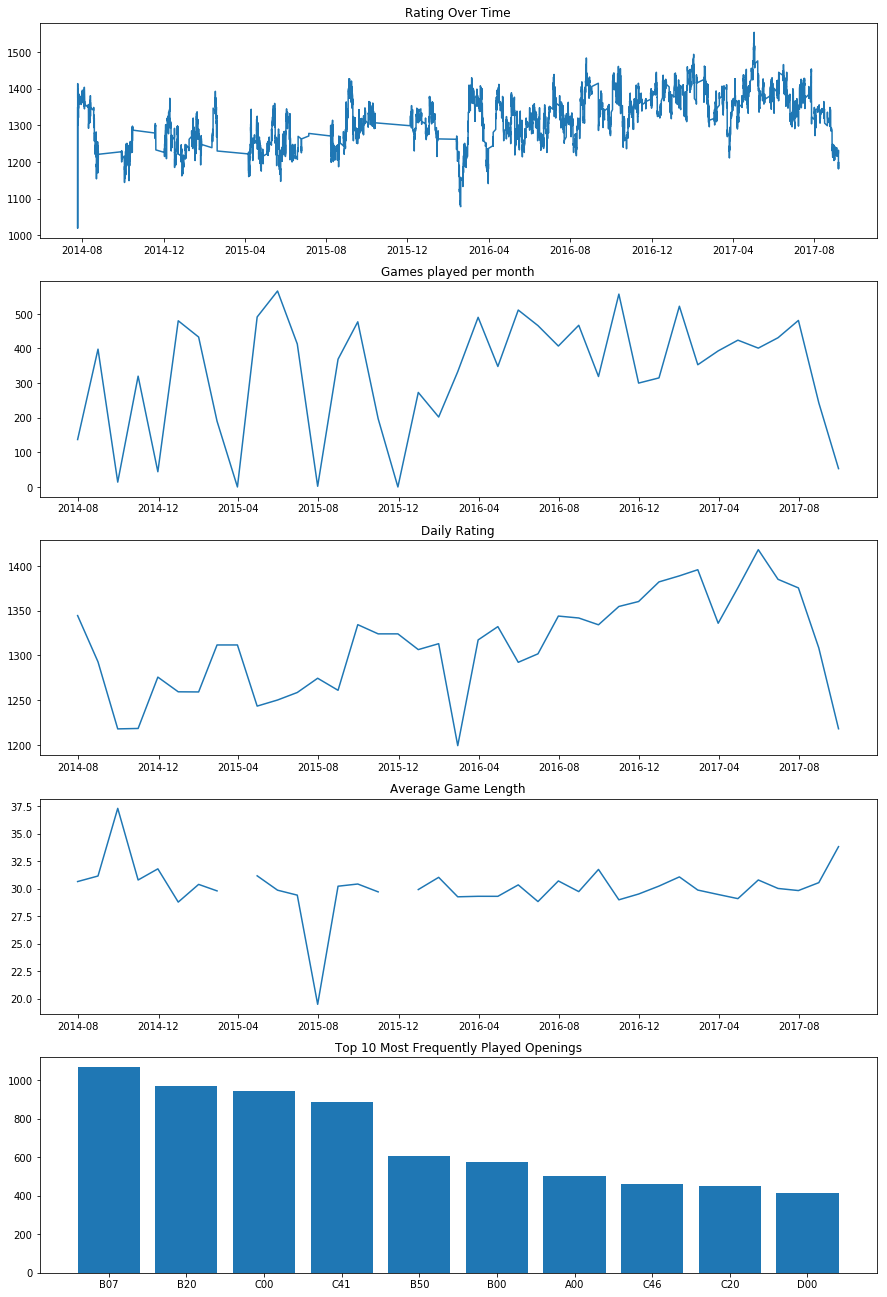

In [317]:
fig, ax = plt.subplots(5, figsize=(15, 23))

blitz_chess_df = stats_df[(stats_df['rules'] == 'chess') & (stats_df['time_class'] == 'blitz')]

ax[0].plot(blitz_chess_df['end_time'], blitz_chess_df['player_rating'])
ax[0].set_title('Rating Over Time')

ax[1].plot(blitz_chess_df.resample('M', on='end_time').count()['eco'])
ax[1].set_title('Games played per month')

ax[2].plot(blitz_chess_df.resample('M', on='end_time').mean()['player_rating'].fillna(method='ffill'))
ax[2].set_title('Daily Rating')

ax[3].plot(blitz_chess_df.resample('M', on='end_time').mean()['game_length'])
ax[3].set_title('Average Game Length')

games_played = blitz_chess_df.eco.value_counts()[:10].values
openings = blitz_chess_df.eco.value_counts()[:10].index
x = np.arange(10)

ax[4].bar(x, games_played)
ax[4].set_title('Top 10 Most Frequently Played Openings')
plt.xticks(x, openings);

In [180]:
def plot_rating_games(username):
    stats_df = game_stats_df(username)
    fig, ax = plt.subplots(3, figsize=(15, 12))

    blitz_chess_df = stats_df[(stats_df['rules'] == 'chess') & (stats_df['time_class'] == 'blitz')]

    ax[0].plot(blitz_chess_df['end_time'], blitz_chess_df['player_rating'])
    ax[0].set_title('Rating Over Time')

    ax[1].plot(blitz_df.resample('W', on='end_time').count()['eco'])
    ax[1].set_title('Games played per month')

    ax[2].plot(blitz_df.resample('D', on='end_time').mean()['player_rating'].fillna(method='ffill'))
    ax[2].set_title('Daily Rating')
    
    ax[3].plot(stats_df.resample('D', on='end_time').mean()['game_length'])
    ax[3].set_title('Average Game Length')

In [230]:
stats_df.head()

,eco,end_time,game_length,pgn,player_rating,player_result,player_username,rated,rules,time_class
0,A40,2018-06-05 05:35:21,6,1. d4 {[%clk 0:09:53.1]} 1... b6 {[%clk 0:09:5...,962,win,bubbasparx666,True,chess,blitz
1,A00,2018-06-05 05:56:05,31,1. g4 {[%clk 0:09:59.9]} 1... Nc6 {[%clk 0:09:...,843,timeout,bubbasparx666,True,chess,blitz
2,B01,2018-06-05 07:21:12,58,1. e4 {[%clk 0:15:02.2]} 1... d5 {[%clk 0:15:0...,622,checkmated,bubbasparx666,True,chess,standard
3,C25,2018-06-08 06:15:45,25,1. e4 {[%clk 0:15:07.6]} 1... e5 {[%clk 0:15:0...,503,checkmated,bubbasparx666,True,chess,standard
4,C41,2018-06-08 06:33:39,25,1. e4 {[%clk 0:15:07.7]} 1... e5 {[%clk 0:15:0...,628,win,bubbasparx666,True,chess,standard
